## Normal Pipeline (without fine-tuning CLIP Model)

In [12]:
!pip freeze > requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [43]:
import torch
torch_device  = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_device_name())
print(f"Using device: {torch_device}")

NVIDIA L40
Using device: cuda


In [44]:
from transformers import CLIPTextModel, CLIPTokenizer, CLIPModel, CLIPProcessor
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from diffusers import LMSDiscreteScheduler


In [45]:
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [46]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")

In [47]:
vae = vae.to(torch_device)
unet = unet.to(torch_device)

text_encoder = text_encoder.to(torch_device)

In [48]:
prompt = ["a photo of an astronaut riding a horse on mars"]

height = 512
width = 512

num_inference_steps = 25
guidance_scale = 7.5
generator = torch.Generator(device='cpu').manual_seed(32)

batch_size = 1

In [49]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]



In [50]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


In [51]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [52]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator
)
latents = latents.to(torch_device)

/tmp/ipykernel_9915/1576514262.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [53]:
latents.shape


torch.Size([1, 4, 64, 64])

In [54]:
scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm

for t in tqdm(scheduler.timesteps):

    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/25 [00:00<?, ?it/s]

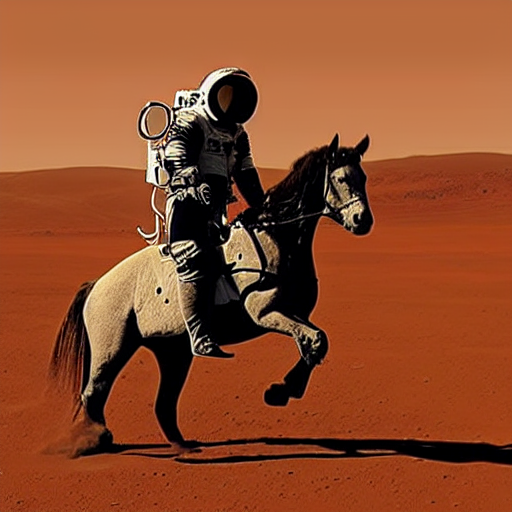

In [14]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
pil_images[0].save('non_finetuned.png')

## Modified Pipeline (with fine-tuned CLIP Model)

In [15]:
import pandas as pd

# Read the dataset from the folders
flickr8k_df = pd.read_csv("./flickr8k/captions.txt",delimiter=",",header=0)
flickr8k_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
from torchvision import transforms
import os

# Transform for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# PyTorch Dataset
class Flickr8kDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_folder, processor, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image'])
        image = Image.open(image_path).convert("RGB")
        caption = row['caption']
        
        # Preprocess image and text
        inputs = self.processor(text=[caption], images=image, return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        return inputs["pixel_values"].squeeze(0), inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)


# Create Dataset and DataLoader
dataset = Flickr8kDataset(flickr8k_df, "./flickr8k/Images", processor=processor, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

for images, input_ids, attention_mask in dataloader:
    print(images.shape)
    print(input_ids.shape)
    print(attention_mask.shape)
    break


torch.Size([32, 3, 224, 224])
torch.Size([32, 77])
torch.Size([32, 77])


In [17]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_model = clip_model.to(torch_device)

In [18]:
import torch.nn.functional as F
from torch.optim import AdamW

# Optimizer
optimizer = AdamW(clip_model.parameters(), lr=5e-6)

In [19]:
from tqdm.auto import tqdm

In [20]:
def train_clip(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for images, input_ids, attention_mask in tqdm(dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=images)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # Compute contrastive loss
        labels = torch.arange(len(images)).to(device)
        loss_img = F.cross_entropy(logits_per_image, labels)
        loss_txt = F.cross_entropy(logits_per_text, labels)
        loss = (loss_img + loss_txt) / 2

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
epochs = 5

for epoch in range(epochs):
    avg_loss = train_clip(clip_model, dataloader, optimizer, torch_device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [22]:
text_encoder_ft = clip_model.text_model

In [23]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [26]:
text_encoder_ft = text_encoder_ft.to(torch_device)
vae = vae.to(torch_device)
unet = unet.to(torch_device)


In [27]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")

In [32]:
prompt = ["a photo of an astronaut riding a horse on mars"]

height = 512
width = 512

num_inference_steps = 25
guidance_scale = 7.5
generator = torch.Generator(device='cpu').manual_seed(32)

batch_size = 1

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder_ft(text_input.input_ids.to(torch_device))[0]



In [33]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


In [34]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [37]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator
)
latents = latents.to(torch_device)

/tmp/ipykernel_9915/1576514262.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [38]:
scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma

In [39]:
from tqdm.auto import tqdm

for t in tqdm(scheduler.timesteps):

    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/25 [00:00<?, ?it/s]

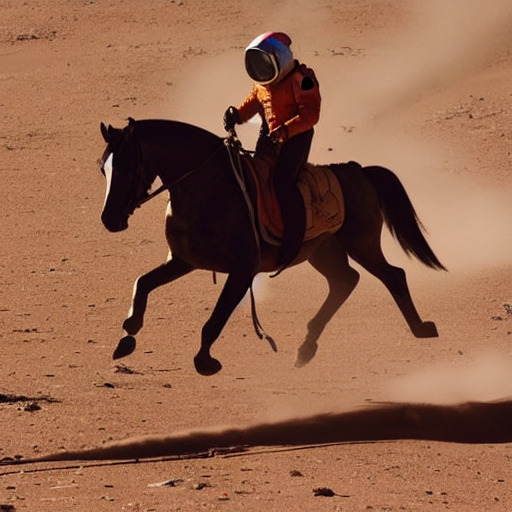

In [40]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [42]:
pil_images[0].save('finetuned.png')